In [28]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [2]:
df = pd.read_csv("../outputs/expected_variants_stats_no_cpg.tsv", sep="\t")
df = df[["enst","csq","n_pos","prop_exp","n_exp","prop_obs","n_obs","oe","oe_diff","z","p"]]

In [3]:
df = df.set_index(["enst","csq"]).unstack("csq")

In [4]:
df.columns = df.columns.swaplevel(0,1)
df.sort_index(axis=1, level=0, inplace=True)

In [5]:
df.shape

(19623, 27)

In [6]:
m1 = df["synonymous","n_obs"] > 10
m2 = df["synonymous","z"] > -1.96
m3 = df["missense","n_obs"] > 10

df = df[m1 & m2 & m3]

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2288: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


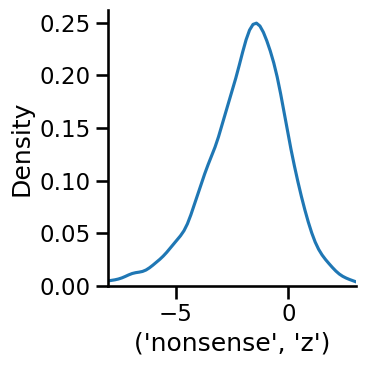

In [38]:
g = sns.displot(kind="kde", data=df, x=("nonsense","z"), height=4)
g.set(xlim=(-8,3))

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2288: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


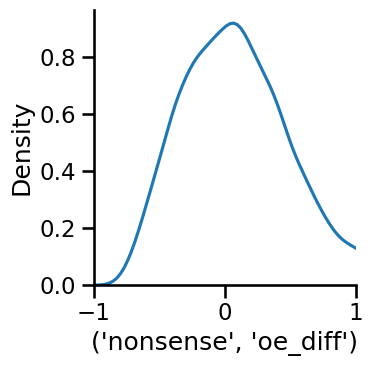

In [35]:
g = sns.displot(kind="kde", data=df, x=("nonsense","oe_diff"), height=4)
g.set(xlim=(-1,1))